In [ ]:
# !python -m spacy download fr_core_news_sm

In [25]:
import torch
from torch import nn
import os
from torchtext.data.utils import get_tokenizer
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm import tqdm
import random
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import unicodedata
from unidecode import unidecode
import re

In [28]:
# Normalize string
def normalizeString(s):
    s = unidecode(s.lower())
    return s

In [162]:
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>'] # UNK for unknown words
NUMBER_OF_SENTENCES = 1000

In [29]:
# Open data file and read lines
with open("./data/pol.txt") as f:
    lines = f.readlines()

# For each line split it by TAB
for i, line in enumerate(lines):
    line = line.split('\t')
    lines[i] = [normalizeString(line[0]), normalizeString(line[1])]



In [37]:
# Print example line
print(lines[random.randint(0, 1000)])

['be strong.', 'badz silny.']


In [38]:
# Create tokenizers
pl_tokenizer = spacy.load("pl_core_news_sm")
en_tokenizer = spacy.load("en_core_web_sm")

In [46]:
# Test tokenizer
tokens = pl_tokenizer(lines[0][1])
print('Number of tokens:', len(tokens))
for token in tokens:
    print(token)

Number of tokens: 2
idz
.


In [118]:
# Lists for storing Polish and English sentences
pl_list = []
en_list = []

# Lists for storing number of tokens in sentences 
pl_lengths = []
en_lengths = []

for line in tqdm(lines[:NUMBER_OF_SENTENCES]):
    # Tokenize sentences
    en_tokens = en_tokenizer(line[0])
    pl_tokens = pl_tokenizer(line[1])

    # Concatenate tokens to lists (each tokenized sentence is different element in the list)
    pl_list += pl_tokens
    en_list += en_tokens

    # Append number of tokens in sentences
    pl_lengths.append(len(pl_tokens))
    en_lengths.append(len(en_tokens))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 52.97it/s]


In [124]:
# Split sentences into string tokens 
pl_token_list = [str(token) for token in pl_list]
en_token_list = [str(token) for token in en_list]

# Counter object works similar to dictionary in which each element is key and value is number of times this element is present
pl_counter = Counter()
en_counter = Counter()

for token in pl_token_list:
    pl_counter[token] += 1
for token in en_token_list:
    en_counter[token] += 1

In [129]:
# Extract 10 most common tokens
en_most_common = en_counter.most_common(10)
pl_most_common = pl_counter.most_common(10)

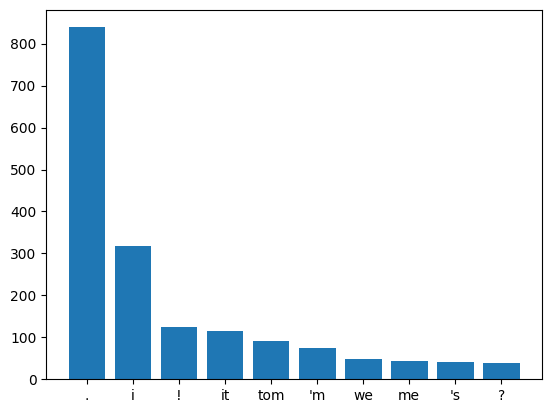

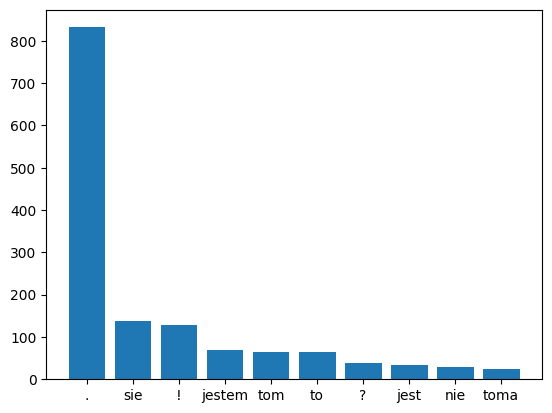

In [143]:
# Bar plots of most common tokens
plt.bar([token[0] for token in en_most_common], [token[1] for token in en_most_common])
plt.show()
plt.bar([token[0] for token in pl_most_common], [token[1] for token in pl_most_common])
plt.show()

In [144]:
# Example tokens
print('Polish tokens: ', pl_list[:20])
print('English tokens: ', en_list[:20])

Polish tokens:  [idz, ., czesc, ., uciekaj, !, biegnij, ., uciekaj, ., kto, ?, o, ,, dziamdzia, zaprzala, jej, szadz, !, lal]
English tokens:  [go, ., hi, ., run, !, run, ., run, ., who, ?, wow, !, wow, !, duck, !, fire, !]


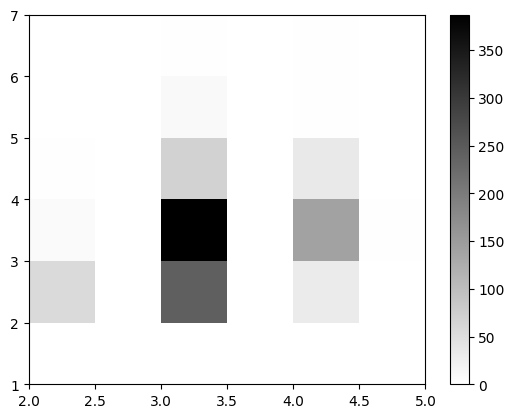

In [155]:
# Sentence lengths comparison
plt.hist2d(en_lengths, pl_lengths, cmap='binary', bins=6)
plt.colorbar()

In [157]:
# Create torchtext Vocabs from lists of tokens
en_vocab = build_vocab_from_iterator([en_token_list])
pl_vocab = build_vocab_from_iterator([pl_token_list])

In [179]:
VALID_PCT = 0.1
TEST_PCT  = 0.1

train_data = []
valid_data = []
test_data = []

random.seed(6547)
for (en, pl) in lines[:NUMBER_OF_SENTENCES]:
    # Tokenizes words, takes each token and gets item from torchtext Vocab. __getitem__ from torchtext Vocab returns index of this token
    en_tensor_ = torch.tensor([en_vocab[str(token)] for token in en_tokenizer(en)])
    pl_tensor_ = torch.tensor([pl_vocab[str(token)] for token in pl_tokenizer(pl)]) 
    
    # Gets random number from 0 to 1 and adds the token to the appropriate dataset
    random_draw = random.random()
    if random_draw <= VALID_PCT:
        valid_data.append((en_tensor_, pl_tensor_))
    elif random_draw <= VALID_PCT + TEST_PCT:
        test_data.append((en_tensor_, pl_tensor_))
    else:
        train_data.append((en_tensor_, pl_tensor_))


print(f"""
  Training pairs: {len(train_data):,}
Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")


  Training pairs: 815
Validation pairs: 74
      Test pairs: 111


In [180]:
# Print comparison of one sentence
tokens = pl_tokenizer(lines[0][1])
print('Number of tokens:', len(tokens))
print('List of tokens:', [token for token in tokens])
print('List of vocab tensor tokens:', train_data[0][1])

Number of tokens: 2
List of tokens: [idz, .]
List of vocab tensor tokens: tensor([18,  0])


In [ ]:
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

for en_id, fr_id in zip(en_vocab.lookup_indices(SPECIALS), pl_vocab.lookup_indices(SPECIALS)):
  assert en_id == fr_id

NameError: name 'en_vocab' is not defined

In [ ]:
def generate_batch(data_batch):
    '''
    Prepare English and French examples for batch-friendly modeling by appending
    BOS/EOS tokens to each, stacking the tensors, and filling trailing spaces of
    shorter sentences with the <pad> token. To be used as the collate_fn in the
    English-to-French DataLoader.

    Input: 
    - data_batch, an iterable of (English, French) tuples from the datasets 
      created above

    Outputs
    - en_batch: a (max length X batch size) tensor of English token IDs
    - fr_batch: a (max length X batch size) tensor of French token IDs 
    '''
    en_batch, fr_batch = [], []
    for (en_item, fr_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))

    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, fr_batch

In [ ]:
BATCH_SIZE = 16

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)


In [ ]:
sentence_pairs

['Go. ###Idź.',
 'Hi. ###Cześć.',
 'Run! ###Uciekaj!',
 'Run. ###Biegnij.',
 'Run. ###Uciekaj.',
 'Who? ###Kto?',
 'Wow! ###O, dziamdzia zaprzała jej szadź!',
 'Wow! ###Łał!',
 'Duck! ###Unik!',
 'Fire! ###Pali się!',
 'Fire! ###Strzelaj!',
 'Fire! ###Ognia!',
 'Help! ###Pomocy!',
 'Hide. ###Schowaj się.',
 'Jump! ###Skacz!',
 'Jump. ###Skok.',
 'Stay. ###Zostań.',
 'Stop! ###Stój!',
 'Stop! ###Zatrzymaj się!',
 'Wait! ###Czekaj!',
 'Wait! ###Zaczekaj!',
 'Wait! ###Poczekaj!',
 'Wait! ###Czekajcie!',
 'Wait! ###Poczekajcie!',
 'Wait! ###Zaczekajcie!',
 'Wait! ###Niech pan zaczeka!',
 'Wait! ###Niech pani zaczeka!',
 'Wait. ###Czekajcie.',
 'Wait. ###Zaczekaj.',
 'Wait. ###Czekaj.',
 'Wait. ###Poczekaj.',
 'Wait. ###Poczekajcie.',
 'Wait. ###Zaczekajcie.',
 'Begin. ###Zaczynaj.',
 'Begin. ###Zaczynajcie.',
 'Do it. ###Zrób to.',
 'Hello! ###Cześć.',
 'Hello. ###Cześć.',
 'Hurry! ###Pośpiesz się!',
 'I hid. ###Ukryłem się.',
 'I ran. ###Pobiegłem.',
 'I ran. ###Pobiegłam.',
 'I see. ###R

In [ ]:
MAX_SENTENCE_LENGTH = 20

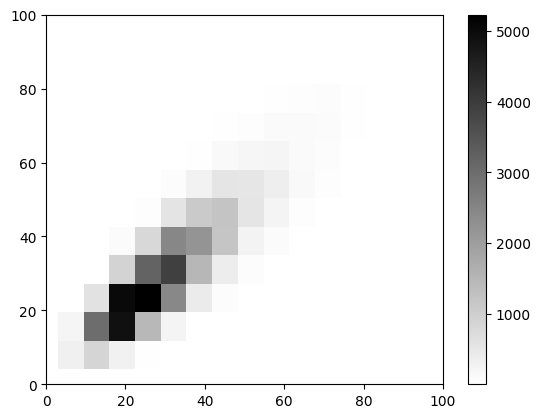

In [ ]:
ENCODER_EMBEDDING_DIM = 256
DECODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_DIM = 256
DECODER_HIDDEN_DIM = 256
SAVE_DIR = os.path.join(".", "models")

In [ ]:
class BahdanauSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

    def forward(self, x):
        outputs, hidden = self.encoder(x)


class BahdanauEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim,
                 encoder_hidden_dim, decoder_hidden_dim, dropout_p):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, encoder_hidden_dim,
                          bidirectional=True)
        # Times 2 because of bidirectional (I guess)
        self.linear = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.gru(embedded)
        hidden = torch.tanh(self.linear(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]),
                      dim=1)
        ))
        return outputs, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, query_size=None,
                 key_size=None, dropout_p=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.query_size = hidden_size if query_size is None else query_size
        # Assume that encoder is bidirectional (times 2)
        self.key_size = 2*hidden_size if key_size is None else key_size

        self.query_layer = nn.Linear(self.query_size, hidden_size)
        self.key_layer = nn.Linear(self.key_size, hidden_size)
        self.energy_layer = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, hidden, encoder_outputs, src_mask=None):
        query_out = self.query_layer(hidden)
        key_out = self.key_layer(encoder_outputs)
        energy_input = torch.tanh(query_out + key_out)
        energies = self.energy_layer(energy_input).squeeze(2)

        if src_mask is not None:
            energies.data.masked_fill_(src_mask == 0, float("-inf"))

        weights = torch.softmax(energies, dim=0)
        return weights.transpose(0, 1)


class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim,
                 decoder_hidden_dim, attention, dropout_p):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = attention
        self.gru = nn.GRU((encoder_hidden_dim*2) +
                          embedding_dim, decoder_hidden_dim)
        self.out = nn.Linear((encoder_hidden_dim*2) +
                             embedding_dim+decoder_hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden, encoder_outputs, src_mask=None):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        attentions = self.attention(hidden, encoder_outputs, src_mask)
        a = attentions.unsqueeze(1)
        encoder_outputs = encoder_outputs.transpose(0, 1)

        '''Multiplying two matrices that are batched. If 1st batched matrix size is (10, 3, 5) 
        and 2nd batched matrix size is (10, 5, 6) then output matrix size will be (10, 3, 6)'''
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.transpose(0, 1)

        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        linear_input = torch.cat((output, weighted, embedded), dim=1)

        output = self.out(linear_input)
        return output, hidden.squeeze(0), attentions


In [ ]:
def main():

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    enc = BahdanauEncoder(len(en_vocab), ENCODER_EMBEDDING_DIM,
                          ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, 0.15)
    attn = BahdanauAttention(DECODER_HIDDEN_DIM)
    dec = BahdanauDecoder(len(fr_vocab), DECODER_EMBEDDING_DIM,
                          ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, attn, 0.15)
    seq2seq = BahdanauSeq2Seq(enc, dec, device)


if __name__ == '__main__':
    main()

NameError: name 'en_vocab' is not defined